# User behavior

 ## Contents <a id='back'></a>
 * [Introduction](#intro)
     * [Project Puropse](#project_puropse)
     * [Data Description](#data_description)
 * [Task decomposition](#task_decomposition)
     * [Open the data file](#open_the_data_file)
     * [Prepare the data for analysis](#prepare_the_data_for_analysis)
     * [Study and check the data](#study_and_check_the_data)
     * [Study the event funnel](#study_the_event_funnel)
     * [Study the results of the experiment](#study_the_results_of_the_experiment)

## Introduction <a id='data_review'></a>

Investigation into user behavior for a company's app

### Project Puropse

Make a decition based on the test results of the user behavior analysis

### Project Description

You work at a startup that sells food products. You need to investigate user behavior for the company's app.
First study the sales funnel. Find out how users reach the purchase stage. How many users actually make it to this stage? How many get stuck at previous stages? Which stages in particular?

Then look at the results of an A/A/B test. (Read on for more information about A/A/B testing.) The designers would like to change the fonts for the entire app, but the managers are afraid the users might find the new design intimidating. They decide to make a decision based on the results of an A/A/B test. 

The users are split into three groups: two control groups get the old fonts and one test group gets the new ones. Find out which set of fonts produces better results.

Creating two A groups has certain advantages. We can make it a principle that we will only be confident in the accuracy of our testing when the two control groups are similar. If there are significant differences between the A groups, this can help us uncover factors that may be distorting the results. Comparing control groups also tells us how much time and data we'll need when running further tests.

You'll be using the same dataset for general analytics and for A/A/B analysis. In real projects, experiments are constantly being conducted. Analysts study the quality of an app using general data, without paying attention to whether users are participating in experiments.


### Data Description

- Each log entry is a user action or an event. 
    - `EventName` — event name
    - `DeviceIDHash` — unique user identifier
    - `EventTimestamp` — event time
    - `ExpId` — experiment number: 246 and 247 are the control groups, 248 is the test group

    
## **Task decomposition:** <a id='data_review'></a>
- Step 1. Open the data file and read the general information
- Step 2. Prepare the data for analysis
- Step 3. Study and check the data
- Step 4. Study the event funnel
- Step 5. Study the results of the experiment

## Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import factorial
from scipy import stats as st
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

## Step 1. Open the data file and read the general information

In [2]:
# Load the data file into a DataFrame

df = pd.read_csv('/datasets/logs_exp_us.csv', delimiter='\t')

In [3]:
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


## Step 2. Prepare the data for analysis

### Rename the columns in a way that's convenient for you

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
# Rename columns
df = df.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id',
    'EventTimestamp': 'event_time',
    'ExpId': 'experiment_id'
})


In [6]:
df

,event_name,device_id,event_time,experiment_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


### Check for missing values and data types. Correct the data if needed

In [7]:
missing_values = df.isnull().sum()
print(missing_values)

event_name       0
device_id        0
event_time       0
experiment_id    0
dtype: int64


**General Conclution**

The data does not contain missing values

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   event_name     244126 non-null  object
 1   device_id      244126 non-null  int64 
 2   event_time     244126 non-null  int64 
 3   experiment_id  244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**General Conclution**

The data type is correct

### Add a date and time column and a separate column for dates

In [9]:
# Change 'event_time' coloumn from Unix timestamp format
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')

# Add a column for dates
df['date'] = df['event_time'].dt.date

# Add a column for the time
df['time'] = df['event_time'].dt.time

# Display DataFrame
df

,event_name,device_id,event_time,experiment_id,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,21:12:25
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21:13:59
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21:14:43
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21:14:58


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event_name     244126 non-null  object        
 1   device_id      244126 non-null  int64         
 2   event_time     244126 non-null  datetime64[ns]
 3   experiment_id  244126 non-null  int64         
 4   date           244126 non-null  object        
 5   time           244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.2+ MB


## Step 3. Study and check the data

### How many events are in the logs?

In [11]:
# Count the events in the log
total_events = df.shape[0]
print("Total number of events:", total_events)

Total number of events: 244126


### How many users are in the logs?

In [12]:
# Count the users in the log
unique_users = df['device_id'].nunique()
print("Number of unique users:", unique_users)

Number of unique users: 7551


### What's the average number of events per user?

In [13]:
# Calculate average number of events per user
average_events_per_user = total_events / unique_users
average_events_per_user_rounded = round(average_events_per_user)
print("Average number of events per user (rounded):", average_events_per_user_rounded)

Average number of events per user (rounded): 32


### What period of time does the data cover? 

#### Find the maximum and the minimum date. Plot a histogram by date and time. 

In [14]:
# Calculate the maximum and minimum date
max_date = df['event_time'].max()
min_date = df['event_time'].min()

print("Maximum Date:", max_date)
print("Minimum Date:", min_date)

Maximum Date: 2019-08-07 21:15:17
Minimum Date: 2019-07-25 04:43:36


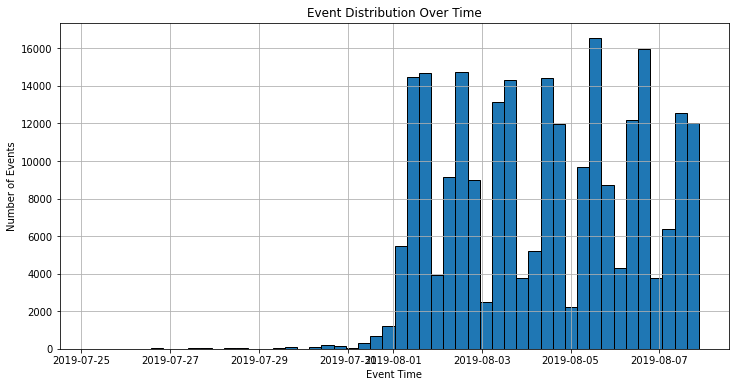

In [15]:
# Plot a histogram by date and time
plt.figure(figsize=(12, 6))
df['event_time'].hist(bins=50, edgecolor='black')
plt.title('Event Distribution Over Time')
plt.xlabel('Event Time')
plt.ylabel('Number of Events')
plt.show()

#### Can you be sure that you have equally complete data for the entire period? Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. Find the moment at which the data starts to be complete and ignore the earlier section. What period does the data actually represent?

- the moment at which the data starts to be complete is at **2019-08-01**

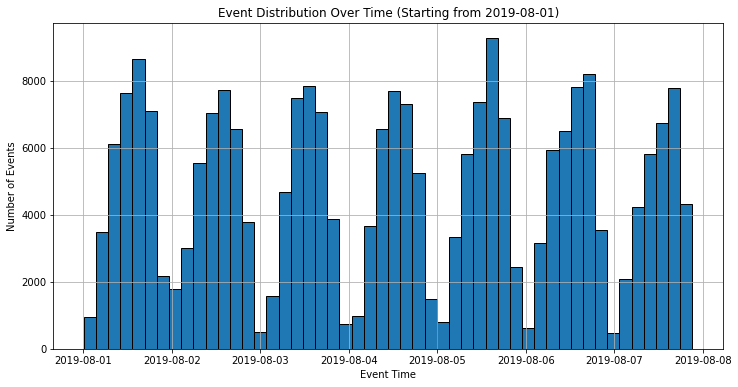

In [16]:
# Set the start date to August 1, 2019
start_date = '2019-08-01'
df_filtered = df[df['event_time'] >= start_date]

# Plot a histogram by date and time for the filtered data
plt.figure(figsize=(12, 6))
df_filtered['event_time'].hist(bins=50, edgecolor='black')
plt.title('Event Distribution Over Time (Starting from 2019-08-01)')
plt.xlabel('Event Time')
plt.ylabel('Number of Events')
plt.show()

### Did you lose many events and users when excluding the older data?

In [17]:
# Set the last date
last_date = '2019-08-01'

# Filter events before the cutoff date
events_before_last = df[df['event_time'] < last_date]

# Count the number of events before the cutoff date
num_events_before_last = len(events_before_last)

# Calculate the percentage of events before the cutoff date
percentage_before_last = (num_events_before_last / total_events) * 100

print("Number of events before {}: {}".format(last_date, num_events_before_last))
print("Percentage of events before {}: {:.2f}%".format(last_date, percentage_before_last))

Number of events before 2019-08-01: 2828
Percentage of events before 2019-08-01: 1.16%


**General Conclucion**

The Data lost accounts for **1.16%** of the entire data set we dod not lose alot of data

### Make sure you have users from all three experimental groups.

In [18]:
unique_experiment_ids = df['experiment_id'].nunique()
print("Unique number of experiment_id:", unique_experiment_ids)

Unique number of experiment_id: 3


## Step 4. Study the event funnel

In [19]:
df

,event_name,device_id,event_time,experiment_id,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,21:12:25
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21:13:59
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21:14:43
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21:14:58


In [20]:
# Create three separate DataFrames based on experiment_id
df_247 = df[df['experiment_id'] == 247]
df_248 = df[df['experiment_id'] == 248]
df_246 = df[df['experiment_id'] == 246]

# Print the first few rows of each DataFrame
print("df_247:")
display(df_247.head())

print("\ndf_248:")
display(df_248.head())

print("\ndf_246:")
display(df_246.head())

df_247:


,event_name,device_id,event_time,experiment_id,date,time
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25,20:31:42
10,MainScreenAppear,948465712512390382,2019-07-26 05:33:34,247,2019-07-26,05:33:34
13,MainScreenAppear,2140904690380565988,2019-07-26 07:22:12,247,2019-07-26,07:22:12
16,MainScreenAppear,5839517684026830712,2019-07-26 11:43:41,247,2019-07-26,11:43:41
18,CartScreenAppear,2575393697599976818,2019-07-26 13:49:05,247,2019-07-26,13:49:05



df_248:


,event_name,device_id,event_time,experiment_id,date,time
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25,11:48:43
11,MainScreenAppear,2547684315586332355,2019-07-26 06:50:26,248,2019-07-26,06:50:26



df_246:


,event_name,device_id,event_time,experiment_id,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25,14:50:42
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25,20:14:37
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26,03:35:12


### See what events are in the logs and their frequency of occurrence. Sort them by frequency.

In [21]:
# Calculate the event Frequency
event_frequency = df['event_name'].value_counts().reset_index()
event_frequency.columns = ['event_name', 'frequency']

# Sort the events by frequency
sorted_event_frequency = event_frequency.sort_values(by='frequency', ascending=False)

# Print the sorted events and their frequencies
print("Events and their frequency of occurrence:")
sorted_event_frequency

Events and their frequency of occurrence:


,event_name,frequency
0,MainScreenAppear,119205
1,OffersScreenAppear,46825
2,CartScreenAppear,42731
3,PaymentScreenSuccessful,34313
4,Tutorial,1052


In [22]:
# Calculate and print event frequency for df_247
event_frequency_247 = df_247['event_name'].value_counts().reset_index()
event_frequency_247.columns = ['event_name', 'frequency_247']

sorted_event_frequency_247 = event_frequency_247.sort_values(by='frequency_247', ascending=False)

print("Events and their frequency of occurrence in df_247:")
display(sorted_event_frequency_247)

# Calculate and print event frequency for df_248
event_frequency_248 = df_248['event_name'].value_counts().reset_index()
event_frequency_248.columns = ['event_name', 'frequency_248']

sorted_event_frequency_248 = event_frequency_248.sort_values(by='frequency_248', ascending=False)

print("\nEvents and their frequency of occurrence in df_248:")
display(sorted_event_frequency_248)

# Calculate and print event frequency for df_246
event_frequency_246 = df_246['event_name'].value_counts().reset_index()
event_frequency_246.columns = ['event_name', 'frequency_246']

sorted_event_frequency_246 = event_frequency_246.sort_values(by='frequency_246', ascending=False)

print("\nEvents and their frequency of occurrence in df_246:")
display(sorted_event_frequency_246)

Events and their frequency of occurrence in df_247:


,event_name,frequency_247
0,MainScreenAppear,39710
1,OffersScreenAppear,15344
2,CartScreenAppear,12570
3,PaymentScreenSuccessful,10101
4,Tutorial,350



Events and their frequency of occurrence in df_248:


,event_name,frequency_248
0,MainScreenAppear,41214
1,OffersScreenAppear,16571
2,CartScreenAppear,15342
3,PaymentScreenSuccessful,12242
4,Tutorial,378



Events and their frequency of occurrence in df_246:


,event_name,frequency_246
0,MainScreenAppear,38281
1,OffersScreenAppear,14910
2,CartScreenAppear,14819
3,PaymentScreenSuccessful,11970
4,Tutorial,324


### Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once.

In [23]:
# Count the number of users who performed each action
users_per_event = df.groupby('event_name')['device_id'].nunique()

# Create a new DataFrame to display the results
users_per_event_df = pd.DataFrame({
    'Event': users_per_event.index,
    'Users Count': users_per_event.values
})

# Sort the DataFrame by the number of users in descending order
users_per_event_df = users_per_event_df.sort_values(by='Users Count', ascending=False)

# Calculate the proportion of users who performed the action at least once
total_users = df['device_id'].nunique()
users_per_event_df['Proportion of Users'] = users_per_event_df['Users Count'] / total_users

# Display
users_per_event_df

,Event,Users Count,Proportion of Users
1,MainScreenAppear,7439,0.985168
2,OffersScreenAppear,4613,0.610912
0,CartScreenAppear,3749,0.496491
3,PaymentScreenSuccessful,3547,0.469739
4,Tutorial,847,0.112171


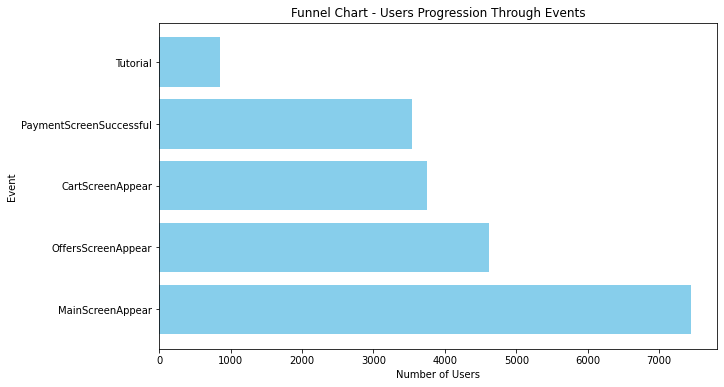

In [24]:
# Sorting the DataFrame by the order of events
events_order = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']
users_per_event_df['Event'] = pd.Categorical(users_per_event_df['Event'], categories=events_order, ordered=True)
users_per_event_df = users_per_event_df.sort_values('Event')

# Create a chart
plt.figure(figsize=(10, 6))
plt.barh(users_per_event_df['Event'], users_per_event_df['Users Count'], color='skyblue')
plt.title('Funnel Chart - Users Progression Through Events')
plt.xlabel('Number of Users')
plt.ylabel('Event')
plt.show()

**Separate the 3 groups**

In [25]:
# Count the number of users who performed each action for df_247
users_per_event_247 = df_247.groupby('event_name')['device_id'].nunique()

# Create a new DataFrame for df_247 to display the results
users_per_event_df_247 = pd.DataFrame({
    'Event': users_per_event_247.index,
    'Users Count_247': users_per_event_247.values
})

# Sort the DataFrame by the number of users in descending order
users_per_event_df_247 = users_per_event_df_247.sort_values(by='Users Count_247', ascending=False)

# Calculate the proportion of users who performed the action at least once for df_247
total_users_247 = df_247['device_id'].nunique()
users_per_event_df_247['Proportion of Users_247'] = users_per_event_df_247['Users Count_247'] / total_users_247

# Display results for df_247
print("Users per event in df_247:")
display(users_per_event_df_247)

# Count the number of users who performed each action for df_248
users_per_event_248 = df_248.groupby('event_name')['device_id'].nunique()

# Create a new DataFrame for df_248 to display the results
users_per_event_df_248 = pd.DataFrame({
    'Event': users_per_event_248.index,
    'Users Count_248': users_per_event_248.values
})

# Sort the DataFrame by the number of users in descending order
users_per_event_df_248 = users_per_event_df_248.sort_values(by='Users Count_248', ascending=False)

# Calculate the proportion of users who performed the action at least once for df_248
total_users_248 = df_248['device_id'].nunique()
users_per_event_df_248['Proportion of Users_248'] = users_per_event_df_248['Users Count_248'] / total_users_248

# Display results for df_248
print("\nUsers per event in df_248:")
display(users_per_event_df_248)

# Count the number of users who performed each action for df_246
users_per_event_246 = df_246.groupby('event_name')['device_id'].nunique()

# Create a new DataFrame for df_246 to display the results
users_per_event_df_246 = pd.DataFrame({
    'Event': users_per_event_246.index,
    'Users Count_246': users_per_event_246.values
})

# Sort the DataFrame by the number of users in descending order
users_per_event_df_246 = users_per_event_df_246.sort_values(by='Users Count_246', ascending=False)

# Calculate the proportion of users who performed the action at least once for df_246
total_users_246 = df_246['device_id'].nunique()
users_per_event_df_246['Proportion of Users_246'] = users_per_event_df_246['Users Count_246'] / total_users_246

# Display results for df_246
print("\nUsers per event in df_246:")
display(users_per_event_df_246)



Users per event in df_247:


,Event,Users Count_247,Proportion of Users_247
1,MainScreenAppear,2482,0.984921
2,OffersScreenAppear,1530,0.607143
0,CartScreenAppear,1240,0.492063
3,PaymentScreenSuccessful,1160,0.460317
4,Tutorial,286,0.113492



Users per event in df_248:


,Event,Users Count_248,Proportion of Users_248
1,MainScreenAppear,2501,0.983871
2,OffersScreenAppear,1538,0.605035
0,CartScreenAppear,1239,0.487411
3,PaymentScreenSuccessful,1185,0.466168
4,Tutorial,282,0.110936



Users per event in df_246:


,Event,Users Count_246,Proportion of Users_246
1,MainScreenAppear,2456,0.986742
2,OffersScreenAppear,1545,0.620731
0,CartScreenAppear,1270,0.510245
3,PaymentScreenSuccessful,1202,0.482925
4,Tutorial,279,0.112093


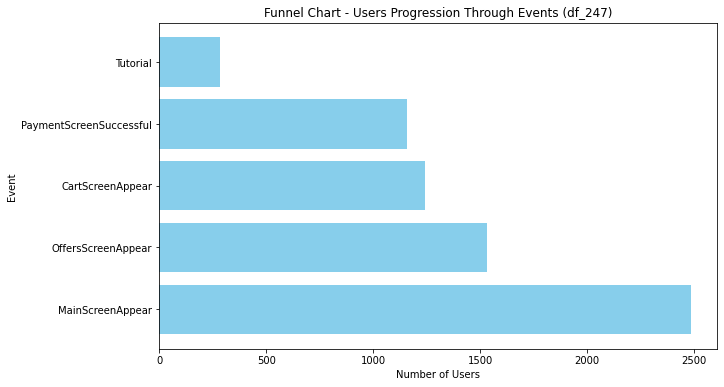

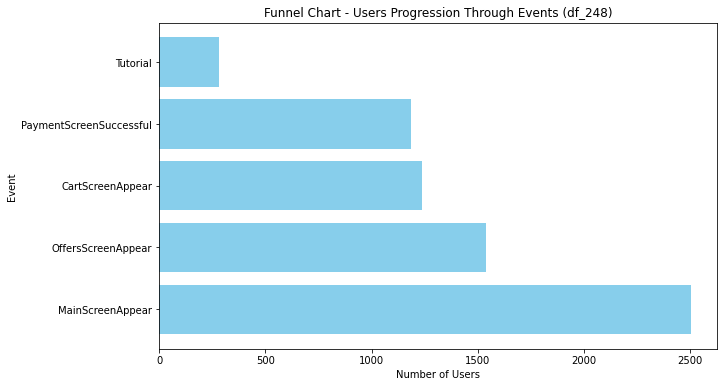

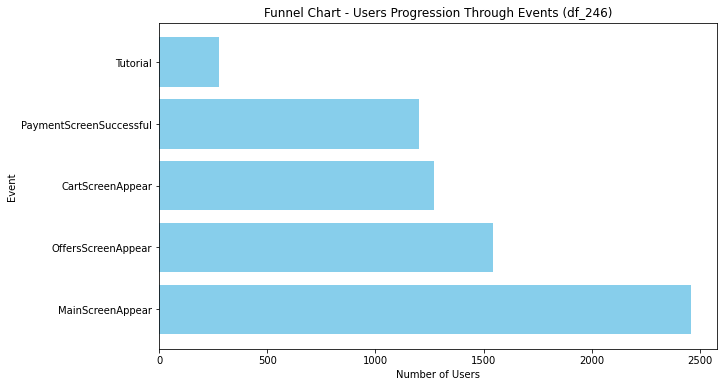

In [26]:
import matplotlib.pyplot as plt

# Define the order of events for the funnel
events_order = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

# Function to create funnel-like horizontal bar chart for df_247
def create_funnel_bar_chart_247(df, title):
    df['Event'] = pd.Categorical(df['Event'], categories=events_order, ordered=True)
    df = df.sort_values('Event')

    plt.figure(figsize=(10, 6))
    plt.barh(df['Event'], df['Users Count_247'], color='skyblue')  # Update the column name here
    plt.title(title)
    plt.xlabel('Number of Users')
    plt.ylabel('Event')
    plt.show()

# Function to create funnel-like horizontal bar chart for df_246
def create_funnel_bar_chart_246(df, title):
    df['Event'] = pd.Categorical(df['Event'], categories=events_order, ordered=True)
    df = df.sort_values('Event')

    plt.figure(figsize=(10, 6))
    plt.barh(df['Event'], df['Users Count_246'], color='skyblue')  # Update the column name here
    plt.title(title)
    plt.xlabel('Number of Users')
    plt.ylabel('Event')
    plt.show()
    
# Function to create funnel-like horizontal bar chart for df_248
def create_funnel_bar_chart_248(df, title):
    df['Event'] = pd.Categorical(df['Event'], categories=events_order, ordered=True)
    df = df.sort_values('Event')

    plt.figure(figsize=(10, 6))
    plt.barh(df['Event'], df['Users Count_248'], color='skyblue')  # Update the column name here
    plt.title(title)
    plt.xlabel('Number of Users')
    plt.ylabel('Event')
    plt.show()    
    
# Create funnel-like horizontal bar charts for df_247, df_248, and df_246
create_funnel_bar_chart_247(users_per_event_df_247, title='Funnel Chart - Users Progression Through Events (df_247)')
create_funnel_bar_chart_248(users_per_event_df_248, title='Funnel Chart - Users Progression Through Events (df_248)')
create_funnel_bar_chart_246(users_per_event_df_246, title='Funnel Chart - Users Progression Through Events (df_246)')

### In what order do you think the actions took place. Are all of them part of a single sequence? 

The Sequence to place in the order of the of the user count: 

* Main Screen Appear
* Offers Screen Appear
* Cart Screen Appear
* Payment Screen Successful
* Tutorial

This is the logical sequence of event is a turorial online purchase

### Use the event funnel to find the share of users that proceed from each stage to the next. (For instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the number of users at stage A and the ratio of users at stage C to the number at stage B.)

In [27]:
# Define the logical sequence of events
events_order = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

# Sorting the DataFrame based on the logical order of events
df['event_name'] = pd.Categorical(df['event_name'], categories=events_order, ordered=True)
df = df.sort_values('event_name')

# Calculate the number of users at each stage
users_per_event = df.groupby('event_name')['device_id'].nunique()

# Calculate the conversion rates
conversion_rates = users_per_event / users_per_event.shift(1)

# Create a DataFrame to display the results
conversion_df = pd.DataFrame({
    'Event': users_per_event.index,
    'Users Count': users_per_event.values,
    'Conversion Rate': conversion_rates.values
})

# Display the result
conversion_df

,Event,Users Count,Conversion Rate
0,MainScreenAppear,7439,NaN
1,OffersScreenAppear,4613,0.620110
2,CartScreenAppear,3749,0.812703
3,PaymentScreenSuccessful,3547,0.946119
4,Tutorial,847,0.238793


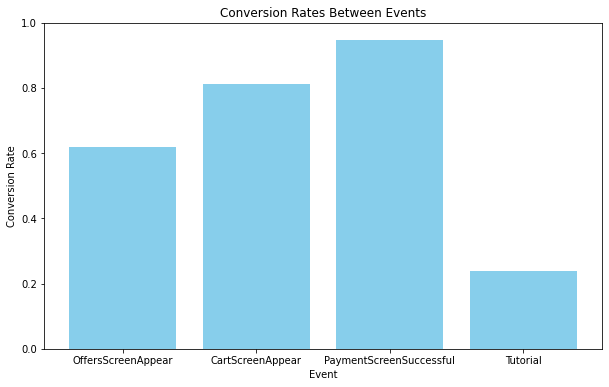

In [28]:
# Create a bar chart for conversion rates
plt.figure(figsize=(10, 6))
plt.bar(conversion_df['Event'], conversion_df['Conversion Rate'], color='skyblue')
plt.title('Conversion Rates Between Events')
plt.xlabel('Event')
plt.ylabel('Conversion Rate')
plt.ylim(0, 1) 
plt.show()

### At what stage do you lose the most users?

In [29]:
conversion_df

,Event,Users Count,Conversion Rate
0,MainScreenAppear,7439,NaN
1,OffersScreenAppear,4613,0.620110
2,CartScreenAppear,3749,0.812703
3,PaymentScreenSuccessful,3547,0.946119
4,Tutorial,847,0.238793


In [30]:
# Create a new column for user loss
conversion_df['User Loss'] = 1 - conversion_df['Conversion Rate']

# Display the updated DataFrame
conversion_df

,Event,Users Count,Conversion Rate,User Loss
0,MainScreenAppear,7439,NaN,NaN
1,OffersScreenAppear,4613,0.620110,0.379890
2,CartScreenAppear,3749,0.812703,0.187297
3,PaymentScreenSuccessful,3547,0.946119,0.053881
4,Tutorial,847,0.238793,0.761207


The stage from "MainScreenAppear" to "OffersScreenAppear" is where most of the users are lost

### What share of users make the entire journey from their first event to payment?

In [31]:
# Given values
users_count_tutorial = 847
users_count_main_screen = 7439

# Calculate the percentage
percentage_tutorial_to_main_screen = (users_count_tutorial / users_count_main_screen) * 100

# Display the result
print(f"Percentage of users from MainScreenAppear to Tutorial: {percentage_tutorial_to_main_screen:.2f}%")

Percentage of users from MainScreenAppear to Tutorial: 11.39%


## Step 5. Study the results of the experiment

### How many users are there in each group?

In [32]:
#Count number in each experiment group
user_counts = df.groupby('experiment_id')['device_id'].nunique()
user_counts

experiment_id
246    2489
247    2520
248    2542
Name: device_id, dtype: int64

**Users in each grou**

* Experiment Group 246 has 2,489 unique users.
* Experiment Group 247 has 2,520 unique users.
* Experiment Group 248 has 2,542 unique users.

### We have two control groups in the A/A test, where we check our mechanisms and calculations. See if there is a statistically significant difference between samples 246 and 247.

**The statistical test**

The statistical test goes about testing which hypothesis is true or which applies to the dataset A t-test is a statistical hypothesis test used to determine if there is a significant difference between the means of two groups or populations. For a two-sample t-test. This test calculates a t-statistic and a p-value to help you decide whether to reject the null hypothesis.

**The Hypothesis**

- Null Hypothesis (H0): There is no significant difference between the average number of unique users in control groups 246 and 247.

- Alternative Hypothesis (H1): There is a significant difference between the average number of unique users in control groups 246 and 247.

In [33]:
# Extract data for control groups 246 and 247
group_246 = df[df['experiment_id'] == 246]['device_id']
group_247 = df[df['experiment_id'] == 247]['device_id']

# Perform t-test
t_statistic, p_value = ttest_ind(group_246, group_247, equal_var=False)

# Print results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

T-statistic: -10.347920410673469
P-value: 4.356389833881039e-25


The P-value is very small and we can therefore reject the null hypothesis. 

**Conclusion**

There is a statistically significant difference between control groups 246 and 247 

### Select the most popular event. In each of the control groups, find the number of users who performed this action. Find their share. Check whether the difference between the groups is statistically significant. Repeat the procedure for all other events (it will save time if you create a special function for this test). Can you confirm that the groups were split properly?

In [34]:
def analyze_event(df, event_name, group1_id, group2_id):
    # Extract data for the event in each control group
    group1_event = df[(df['experiment_id'] == group1_id) & (df['event_name'] == event_name)]['device_id']
    group2_event = df[(df['experiment_id'] == group2_id) & (df['event_name'] == event_name)]['device_id']

    # Perform t-test
    t_statistic, p_value = ttest_ind(group1_event, group2_event, equal_var=False)

    # Print results
    print(f'Event: {event_name}')
    print(f'T-statistic: {t_statistic}')
    print(f'P-value: {p_value}')

    # Check if the difference is statistically significant
    if p_value < 0.05:
        print("The difference is statistically significant.")
    else:
        print("The difference is not statistically significant.")

# Get unique event names
unique_events = df['event_name'].unique()

# Loop through all events and analyze them
for event in unique_events:
    analyze_event(df, event, 246, 247)
    print("\n")

Event: MainScreenAppear
T-statistic: -4.280696655637785
P-value: 1.8653203413000317e-05
The difference is statistically significant.


Event: OffersScreenAppear
T-statistic: -9.312842724277417
P-value: 1.3267504197519732e-20
The difference is statistically significant.


Event: CartScreenAppear
T-statistic: -4.236481026746446
P-value: 2.2779223383582763e-05
The difference is statistically significant.


Event: PaymentScreenSuccessful
T-statistic: -2.759475557342649
P-value: 0.005794198634693325
The difference is statistically significant.


Event: Tutorial
T-statistic: 0.04640786462103255
P-value: 0.9629992675232146
The difference is not statistically significant.




### Do the same thing for the group with altered fonts. Compare the results with those of each of the control groups for each event in isolation. Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment?

In [35]:
def analyze_event(df, event_name, group1_id, group2_id):
    # Extract data for the event in each group
    group1_event = df[(df['experiment_id'] == group1_id) & (df['event_name'] == event_name)]['device_id']
    group2_event = df[(df['experiment_id'] == group2_id) & (df['event_name'] == event_name)]['device_id']

    # Perform t-test
    t_statistic, p_value = ttest_ind(group1_event, group2_event, equal_var=False)

    # Print results
    print(f'Event: {event_name}')
    print(f'T-statistic: {t_statistic}')
    print(f'P-value: {p_value}')

    # Check if the difference is statistically significant
    if p_value < 0.05:
        print("The difference is statistically significant.")
    else:
        print("The difference is not statistically significant.")

# Get unique event names
unique_events = df['event_name'].unique()

# Compare altered fonts group (248) with each control group (246 and 247)
for event in unique_events:
    print(f"\nComparing Altered Fonts Group (248) with Control Group 246 for {event}:")
    analyze_event(df, event, 246, 248)

    print(f"\nComparing Altered Fonts Group (248) with Control Group 247 for {event}:")
    analyze_event(df, event, 247, 248)
    print("\n")

# Compare the combined results for control groups 246 and 247
print("\nCombined results for Control Groups 246 and 247:")
for event in unique_events:
    analyze_event(df, event, 246, 247)
    print("\n")



Comparing Altered Fonts Group (248) with Control Group 246 for MainScreenAppear:
Event: MainScreenAppear
T-statistic: 1.273803350844698
P-value: 0.2027368723043473
The difference is not statistically significant.

Comparing Altered Fonts Group (248) with Control Group 247 for MainScreenAppear:
Event: MainScreenAppear
T-statistic: 5.699432220315091
P-value: 1.2062384423734582e-08
The difference is statistically significant.



Comparing Altered Fonts Group (248) with Control Group 246 for OffersScreenAppear:
Event: OffersScreenAppear
T-statistic: -9.671085533578262
P-value: 4.303870628895964e-22
The difference is statistically significant.

Comparing Altered Fonts Group (248) with Control Group 247 for OffersScreenAppear:
Event: OffersScreenAppear
T-statistic: -0.16116255699005724
P-value: 0.8719663985238744
The difference is not statistically significant.



Comparing Altered Fonts Group (248) with Control Group 246 for CartScreenAppear:
Event: CartScreenAppear
T-statistic: -5.9931780

### What significance level have you set to test the statistical hypotheses mentioned above? Calculate how many statistical hypothesis tests you carried out. With a statistical significance level of 0.1, one in 10 results could be false. What should the significance level be? If you want to change it, run through the previous steps again and check your conclusions.

**The Alpha Value (Significance Level)**

Is the probability of obtaioning a particular value 

- often denoted as α, 
- is the chosen threshold that determines the level of significance in a hypothesis test
- It represents the maximum acceptable probability of making a Type I error (rejection of  the null hypothesis)
- Common alpha values include 0.05 (5%) or 0.01 (1%) 

The significance level (alpha) is set to **0.05 / (5%) ** , which is a common choice in statistical hypothesis testing.

In [36]:
# Count the number of unique events
num_unique_events = len(df['event_name'].unique())

# Count the number of group comparisons
num_group_comparisons = 2 * (len(df['experiment_id'].unique()) - 1)

# Calculate the total number of tests
total_tests = num_unique_events * num_group_comparisons

print(f"Number of unique events: {num_unique_events}")
print(f"Number of group comparisons: {num_group_comparisons}")
print(f"Total number of tests: {total_tests}")

Number of unique events: 5
Number of group comparisons: 4
Total number of tests: 20


**Rerunning tests with  significance level/alpha = 0.1**

#### Select the most popular event. In each of the control groups, find the number of users who performed this action. Find their share. Check whether the difference between the groups is statistically significant. 

In [37]:
def analyze_event(df, event_name, group1_id, group2_id):
    # Extract data for the event in each control group
    group1_event = df[(df['experiment_id'] == group1_id) & (df['event_name'] == event_name)]['device_id']
    group2_event = df[(df['experiment_id'] == group2_id) & (df['event_name'] == event_name)]['device_id']

    # Perform t-test
    t_statistic, p_value = ttest_ind(group1_event, group2_event, equal_var=False)

    # Print results
    print(f'Event: {event_name}')
    print(f'T-statistic: {t_statistic}')
    print(f'P-value: {p_value}')

    # Check if the difference is statistically significant
    if p_value < 0.01:
        print("The difference is statistically significant.")
    else:
        print("The difference is not statistically significant.")

# Get unique event names
unique_events = df['event_name'].unique()

# Loop through all events and analyze them
for event in unique_events:
    analyze_event(df, event, 246, 247)
    print("\n")

Event: MainScreenAppear
T-statistic: -4.280696655637785
P-value: 1.8653203413000317e-05
The difference is statistically significant.


Event: OffersScreenAppear
T-statistic: -9.312842724277417
P-value: 1.3267504197519732e-20
The difference is statistically significant.


Event: CartScreenAppear
T-statistic: -4.236481026746446
P-value: 2.2779223383582763e-05
The difference is statistically significant.


Event: PaymentScreenSuccessful
T-statistic: -2.759475557342649
P-value: 0.005794198634693325
The difference is statistically significant.


Event: Tutorial
T-statistic: 0.04640786462103255
P-value: 0.9629992675232146
The difference is not statistically significant.




#### Do the same thing for the group with altered fonts. Compare the results with those of each of the control groups for each event in isolation. 

In [38]:
def analyze_event(df, event_name, group1_id, group2_id):
    # Extract data for the event in each group
    group1_event = df[(df['experiment_id'] == group1_id) & (df['event_name'] == event_name)]['device_id']
    group2_event = df[(df['experiment_id'] == group2_id) & (df['event_name'] == event_name)]['device_id']

    # Perform t-test
    t_statistic, p_value = ttest_ind(group1_event, group2_event, equal_var=False)

    # Print results
    print(f'Event: {event_name}')
    print(f'T-statistic: {t_statistic}')
    print(f'P-value: {p_value}')

    # Check if the difference is statistically significant
    if p_value < 0.05:
        print("The difference is statistically significant.")
    else:
        print("The difference is not statistically significant.")

# Get unique event names
unique_events = df['event_name'].unique()

# Compare altered fonts group (248) with each control group (246 and 247)
for event in unique_events:
    print(f"\nComparing Altered Fonts Group (248) with Control Group 246 for {event}:")
    analyze_event(df, event, 246, 248)

    print(f"\nComparing Altered Fonts Group (248) with Control Group 247 for {event}:")
    analyze_event(df, event, 247, 248)
    print("\n")

# Compare the combined results for control groups 246 and 247
print("\nCombined results for Control Groups 246 and 247:")
for event in unique_events:
    analyze_event(df, event, 246, 247)
    print("\n")



Comparing Altered Fonts Group (248) with Control Group 246 for MainScreenAppear:
Event: MainScreenAppear
T-statistic: 1.273803350844698
P-value: 0.2027368723043473
The difference is not statistically significant.

Comparing Altered Fonts Group (248) with Control Group 247 for MainScreenAppear:
Event: MainScreenAppear
T-statistic: 5.699432220315091
P-value: 1.2062384423734582e-08
The difference is statistically significant.



Comparing Altered Fonts Group (248) with Control Group 246 for OffersScreenAppear:
Event: OffersScreenAppear
T-statistic: -9.671085533578262
P-value: 4.303870628895964e-22
The difference is statistically significant.

Comparing Altered Fonts Group (248) with Control Group 247 for OffersScreenAppear:
Event: OffersScreenAppear
T-statistic: -0.16116255699005724
P-value: 0.8719663985238744
The difference is not statistically significant.



Comparing Altered Fonts Group (248) with Control Group 246 for CartScreenAppear:
Event: CartScreenAppear
T-statistic: -5.9931780

**Create a table comparison of the results of Aphla 0.05 and 0.01**

In [39]:
# Function to perform t-test and return results
def perform_t_test(df, event_name, group1_id, group2_id, alpha):
    group1_event = df[(df['experiment_id'] == group1_id) & (df['event_name'] == event_name)]['device_id']
    group2_event = df[(df['experiment_id'] == group2_id) & (df['event_name'] == event_name)]['device_id']

    t_statistic, p_value = ttest_ind(group1_event, group2_event, equal_var=False)

    result = {
        'Event': event_name,
        f'T-Statistic (Alpha={alpha})': t_statistic,
        f'P-Value (Alpha={alpha})': p_value,
        f'Significant (Alpha={alpha})': p_value < alpha
    }
    return result

# Get unique event names
unique_events = df['event_name'].unique()

# Create a DataFrame to store the results
results_df = pd.DataFrame()

# Compare altered fonts group (248) with each control group (246 and 247) for both significance levels
for event in unique_events:
    result_005 = perform_t_test(df, event, 246, 248, 0.05)
    result_001 = perform_t_test(df, event, 246, 248, 0.01)

    results_df = results_df.append(result_005, ignore_index=True)
    results_df = results_df.append(result_001, ignore_index=True)

# Fill NaN values with appropriate placeholders
results_df = results_df.fillna('Not applicable')

# Display the results DataFrame
results_df


,Event,P-Value (Alpha=0.05),Significant (Alpha=0.05),T-Statistic (Alpha=0.05),P-Value (Alpha=0.01),Significant (Alpha=0.01),T-Statistic (Alpha=0.01)
0,MainScreenAppear,0.202737,0.0,1.273803,Not applicable,Not applicable,Not applicable
1,MainScreenAppear,Not applicable,Not applicable,Not applicable,0.202737,0.0,1.273803
2,OffersScreenAppear,0.0,1.0,-9.671086,Not applicable,Not applicable,Not applicable
3,OffersScreenAppear,Not applicable,Not applicable,Not applicable,0.0,1.0,-9.671086
4,CartScreenAppear,0.0,1.0,-5.993178,Not applicable,Not applicable,Not applicable
5,CartScreenAppear,Not applicable,Not applicable,Not applicable,0.0,1.0,-5.993178
6,PaymentScreenSuccessful,0.0,1.0,-5.322979,Not applicable,Not applicable,Not applicable
7,PaymentScreenSuccessful,Not applicable,Not applicable,Not applicable,0.0,1.0,-5.322979
8,Tutorial,0.880832,0.0,-0.149972,Not applicable,Not applicable,Not applicable
9,Tutorial,Not applicable,Not applicable,Not applicable,0.880832,0.0,-0.149972
